## Easy_Evaluation
- まず簡単に評価するには、各PlayIdを1行にする必要がある
- GameIdごとに、Team変数のaway, 


- 多分、座標の使い方はプレー方向によって変わるので、それを考慮した特徴にする

In [11]:
import pandas as pd
import numpy as np
import datetime
import yaml
import argparse
import gc
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

In [12]:
df_train = pd.read_csv('../input/train.csv')
print(df_train.shape)
display(df_train.sample(20))

(509762, 49)


,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,NflId,DisplayName,JerseyNumber,Season,YardLine,Quarter,GameClock,PossessionTeam,Down,Distance,FieldPosition,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,OffenseFormation,OffensePersonnel,DefendersInTheBox,DefensePersonnel,PlayDirection,TimeHandoff,TimeSnap,Yards,PlayerHeight,PlayerWeight,PlayerBirthDate,PlayerCollegeName,Position,HomeTeamAbbr,VisitorTeamAbbr,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection
198283,2017121000,20171210004226,home,30.82,27.04,1.66,0.99,0.21,221.30,15.92,2552403,Nick O'Leary,84,2017,18,5,01:46:00,BUF,2,1,IND,7,7,79607,SINGLEBACK,"1 RB, 2 TE, 2 WR",7.0,"3 DL, 4 LB, 4 DB",left,2017-12-10T21:15:42.000Z,2017-12-10T21:15:41.000Z,-3,6-3,252,08/31/1992,Florida State,TE,BUF,IND,14,New Era Field,Orchard Park NY,Outdoors,A-Turf Titan,Heavy lake effect snow,32.0,69.0,15,W
88187,2017101508,20171015081481,home,75.63,26.69,3.07,2.80,0.28,57.49,163.58,744,Calais Campbell,93,2017,34,2,07:39:00,LA,3,1,LA,14,17,2552475,SHOTGUN,"1 RB, 1 TE, 3 WR",7.0,"4 DL, 2 LB, 5 DB",left,2017-10-15T21:10:12.000Z,2017-10-15T21:10:11.000Z,0,6-8,300,09/01/1986,Miami,DE,JAX,LA,6,EverBank Field,"Jacksonville, FL",Open,Grass,30% Chance of Rain,88.0,68.0,10,NE
100753,2017102206,20171022062122,home,81.84,17.44,3.58,2.61,0.45,169.28,226.29,2540202,Kenny Stills,10,2017,28,3,14:25:00,MIA,2,4,MIA,14,21,2552582,SHOTGUN,"1 RB, 1 TE, 3 WR",7.0,"3 DL, 3 LB, 5 DB",left,2017-10-22T18:49:15.000Z,2017-10-22T18:49:14.000Z,0,6-1,202,04/22/1992,Oklahoma,WR,MIA,NYJ,7,Hard Rock Stadium,"Miami Gardens, Fla.",Outdoor,Natural Grass,Partly Cloudy,86.0,67.0,18,ESE
119124,2017102909,20171029090700,home,61.90,20.52,1.98,0.46,0.39,261.08,38.40,2539943,D.J. Swearinger,36,2017,48,1,04:02:00,DAL,4,1,DAL,10,7,2555224,SINGLEBACK,"1 RB, 1 TE, 3 WR",7.0,"2 DL, 4 LB, 5 DB",left,2017-10-29T20:54:28.000Z,2017-10-29T20:54:27.000Z,4,5-10,205,09/01/1991,South Carolina,FS,WAS,DAL,8,FedExField,"Landover, MD",Outdoor,Grass,Rain,60.0,93.0,4,ESE
345372,2018101408,20181014082702,home,90.82,31.35,1.66,1.50,0.15,224.77,198.29,2543489,Morgan Moses,76,2018,20,3,05:03:00,WAS,1,10,WAS,17,9,2507164,SHOTGUN,"1 RB, 2 TE, 2 WR",7.0,"4 DL, 3 LB, 4 DB",left,2018-10-14T19:05:38.000Z,2018-10-14T19:05:37.000Z,4,6-6,330,03/03/1991,Virginia,T,WAS,CAR,6,FedExField,"Landover, MD",Outdoor,Grass,Cloudy,52.0,74.0,0,NaN
26592,2017091710,20170917104510,home,73.57,43.96,2.93,1.88,0.31,0.63,293.97,2552599,Lorenzo Doss,37,2017,33,4,00:47:00,DAL,2,2,DAL,42,17,2553743,SHOTGUN,"1 RB, 1 TE, 3 WR",5.0,"1 DL, 4 LB, 6 DB",left,2017-09-18T00:39:15.000Z,2017-09-18T00:39:14.000Z,0,5-11,185,04/22/1994,Tulane,CB,DEN,DAL,2,Sports Authority Field at Mile High,"Denver, CO",Outdoor,Grass,Partly Cloudy,72.0,41.0,5,SouthWest
454464,2018120907,20181209070268,away,82.49,30.17,3.93,3.06,0.38,325.26,196.84,2558928,Austin Carr,80,2018,28,1,12:14:00,NO,1,10,NO,7,0,2558019,SINGLEBACK,"1 RB, 1 TE, 3 WR",6.0,"4 DL, 2 LB, 5 DB",left,2018-12-09T18:11:53.000Z,2018-12-09T18:11:52.000Z,1,6-1,195,12/25/1993,Northwestern,WR,TB,NO,14,Raymond James Stadium,"Tampa, FL",Outdoor,Natural Grass,Cloudy,71.0,91.0,7,SW
256799,2017123111,20171231110543,home,25.26,34.58,0.93,2.16,0.09,256.84,23.94,2550132,Taylor Lewan,77,2017,15,1,07:31:00,TEN,2,11,TEN,0,0,2556075,SINGLEBACK,"1 RB, 2 TE, 2 WR",8.0,"4 DL, 3 LB, 4 DB",right,2017-12-31T21:45:01.000Z,2017-12-31T21:44:59.000Z,-12,6-7,309,07/22/1991,Michigan,T,TEN,JAX,17,Nissan Stadium,"Nashville, TN",Outdoors,Grass,Clear,23.0,45.0,5,Northeast
197000,2017121000,20171210000849,home,50.93,25.73,3.65,2.09,0.42,1.43,80.06,79607,LeSean McCoy,25,2017,45,2,10:43:00,BUF,1,10,BUF,0,0,79607,I_FORM,"2 RB, 1 TE, 2 WR",7.0,"3 DL, 4 LB, 4 DB",right,2017-12-10T18:39:29.000Z,2017-12-10T18:39:28.000Z,5,5-11,210,07/12/1988,Pittsburgh,RB,BUF,IND,14,New Era Field,Orchard Park NY,Outdoors,A-Turf Titan,Heavy lake effect snow,32.0,69.0,15,W
147291,2017111210,20171112103256,away,50.75,20.77,3.37,2.12,0.32,151.44,170.38,496843,Jas

In [13]:
df_train.select_dtypes('object')

,Team,DisplayName,GameClock,PossessionTeam,FieldPosition,OffenseFormation,OffensePersonnel,DefensePersonnel,PlayDirection,TimeHandoff,TimeSnap,PlayerHeight,PlayerBirthDate,PlayerCollegeName,Position,HomeTeamAbbr,VisitorTeamAbbr,Stadium,Location,StadiumType,Turf,GameWeather,WindSpeed,WindDirection
0,away,Eric Berry,14:14:00,NE,NE,SHOTGUN,"1 RB, 1 TE, 3 WR","2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,6-0,12/29/1988,Tennessee,SS,NE,KC,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,8,SW
1,away,Allen Bailey,14:14:00,NE,NE,SHOTGUN,"1 RB, 1 TE, 3 WR","2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,6-3,03/25/1989,Miami,DE,NE,KC,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,8,SW
2,away,Justin Houston,14:14:00,NE,NE,SHOTGUN,"1 RB, 1 TE, 3 WR","2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,6-3,01/21/1989,Georgia,DE,NE,KC,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,8,SW
3,away,Derrick Johnson,14:14:00,NE,NE,SHOTGUN,"1 RB, 1 TE, 3 WR","2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,6-3,11/22/1982,Texas,ILB,NE,KC,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,8,SW
4,away,Ron Parker,14:14:00,NE,NE,SHOTGUN,"1 RB, 1 TE, 3 WR","2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,6-0,08/17/1987,Newberry,FS,NE,KC,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,8,SW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509757,home,Nick Vannett,00:16:00,SEA,ARZ,SINGLEBACK,"6 OL, 1 RB, 2 TE, 1 WR","4 DL, 3 LB, 4 DB",right,2018-12-31T00:24:51.000Z,2018-12-31T00:24:49.000Z,6-6,03/06/1993,Ohio State,TE,SEA,ARI,CenturyLink Field,"Seattle, WA",Outdoor,FieldTurf,Cloudy,5,SE
509758,home,Germain Ifedi,00:16:00,SEA,ARZ,SINGLEBACK,"6 OL, 1 RB, 2 TE, 1 WR","4 DL, 3 LB, 4 DB",right,2018-12-31T00:24:51.000Z,2018-12-31T00:24:49.000Z,6-5,06/02/1994,Texas A&M,G,SEA,ARI,CenturyLink Field,"Seattle, WA",Outdoor,FieldTurf,Cloudy,5,SE
509759,home,George Fant,00:16:00,SEA,ARZ,SINGLEBACK,"6 OL, 1 RB, 2 TE, 1 WR","4 DL, 3 LB, 4 DB",right,2018-12-31T00:24:51.000Z,2018-12-31T00:24:49.000Z,6-5,07/19/1992,Western Kentucky,OT,SEA,ARI,CenturyLink Field,"Seattle, WA",Outdoor,FieldTurf,Cloudy,5,SE
509760,home,Ethan Pocic,00:16:00,SEA,ARZ,SINGLEBACK,"6 OL, 1 RB, 2 TE, 1 WR","4 DL, 3 LB, 4 DB",right,2018-12-31T00:24:51.000Z,2018-12-31T00:24:49.000Z,6-6,08/05/1995,Louisiana State,C,SEA,ARI,CenturyLink Field,"Seattle, WA",Outdoor,FieldTurf,Cloudy,5,SE


In [14]:
df_train[df_train['PlayId']==20171217033778]

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,NflId,DisplayName,JerseyNumber,Season,YardLine,Quarter,GameClock,PossessionTeam,Down,Distance,FieldPosition,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,OffenseFormation,OffensePersonnel,DefendersInTheBox,DefensePersonnel,PlayDirection,TimeHandoff,TimeSnap,Yards,PlayerHeight,PlayerWeight,PlayerBirthDate,PlayerCollegeName,Position,HomeTeamAbbr,VisitorTeamAbbr,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection
218768,2017121703,20171217033778,away,79.98,25.22,1.60,0.56,0.18,181.33,221.25,758,Breno Giacomini,68,2017,30,4,10:26:00,HST,1,10,HST,45,7,2543600,SHOTGUN,"6 OL, 1 RB, 0 TE, 3 WR",7.0,"4 DL, 2 LB, 5 DB",left,2017-12-17T20:59:04.000Z,2017-12-17T20:59:03.000Z,5,6-7,320,09/27/1985,Louisville,T,JAX,HOU,15,Everbank Field,"Jacksonville, FL",Open,Grass,NaN,72.0,55.0,5,SE
218769,2017121703,20171217033778,away,85.20,23.94,0.65,0.33,0.08,129.84,98.03,2508123,T.J. Yates,2,2017,30,4,10:26:00,HST,1,10,HST,45,7,2543600,SHOTGUN,"6 OL, 1 RB, 0 TE, 3 WR",7.0,"4 DL, 2 LB, 5 DB",left,2017-12-17T20:59:04.000Z,2017-12-17T20:59:03.000Z,5,6-4,217,05/28/1987,North Carolina,QB,JAX,HOU,15,Everbank Field,"Jacksonville, FL",Open,Grass,NaN,72.0,55.0,5,SE
218770,2017121703,20171217033778,away,79.32,13.58,2.45,1.83,0.33,170.34,239.33,2540165,DeAndre Hopkins,10,2017,30,4,10:26:00,HST,1,10,HST,45,7,2543600,SHOTGUN,"6 OL, 1 RB, 0 TE, 3 WR",7.0,"4 DL, 2 LB, 5 DB",left,2017-12-17T20:59:04.000Z,2017-12-17T20:59:03.000Z,5,6-1,212,06/06/1992,Clemson,WR,JAX,HOU,15,Everbank Field,"Jacksonville, FL",Open,Grass,NaN,72.0,55.0,5,SE
218771,2017121703,20171217033778,away,85.04,22.67,2.31,2.66,0.34,193.10,279.99,2543600,Alfred Blue,28,2017,30,4,10:26:00,HST,1,10,HST,45,7,2543600,SHOTGUN,"6 OL, 1 RB, 0 TE, 3 WR",7.0,"4 DL, 2 LB, 5 DB",left,2017-12-17T20:59:04.000Z,2017-12-17T20:59:03.000Z,5,6-2,225,04/27/1991,LSU,RB,JAX,HOU,15,Everbank Field,"Jacksonville, FL",Open,Grass,NaN,72.0,55.0,5,SE
218772,2017121703,20171217033778,away,79.62,22.64,1.31,0.91,0.13,182.83,252.44,2543666,Xavier Su'a-Filo,71,2017,30,4,10:26:00,HST,1,10,HST,45,7,2543600,SHOTGUN,"6 OL, 1 RB, 0 TE, 3 WR",7.0,"4 DL, 2 LB, 5 DB",left,2017-12-17T20:59:04.000Z,2017-12-17T20:59:03.000Z,5,6-4,310,01/01/1991,UCLA,G,JAX,HOU,15,Everbank Field,"Jacksonville, FL",Open,Grass,NaN,72.0,55.0,5,SE
218773,2017121703,20171217033778,away,79.09,30.23,1.55,0.24,0.28,206.17,249.26,2552657,DeAndrew White,11,2017,30,4,10:26:00,HST,1,10,HST,45,7,2543600,SHOTGUN,"6 OL, 1 RB, 0 TE, 3 WR",7.0,"4 DL, 2 LB, 5 DB",left,2017-12-17T20:59:04.000Z,2017-12-17T20:59:03.000Z,5,6-0,195,10/16/1991,Alabama,WR,JAX,HOU,15,Everbank Field,"Jacksonville, FL",Open,Grass,NaN,72.0,55.0,5,SE
218774,2017121703,20171217033778,away,80.23,23.23,1.24,0.93,0.11,152.56,234.60,2553560,Greg Mancz,65,2017,30,4,10:26:00,HST,1,10,HST,45,7,2543600,SHOTGUN,"6 OL, 1 RB, 0 TE, 3 WR",7.0,"4 DL, 2 LB, 5 DB",left,2017-12-17T20:59:04.000Z,2017-12-17T20:59:03.000Z,5,6-4,310,04/23/1992,Toledo,C,JAX,HOU,15,Everbank Field,"Jacksonville, FL",Open,Grass,NaN,72.0,55.0,5,SE
218775,2017121703,20171217033778,away,79.93,24.72,1.25,0.36,0.18,159.24,231.36,2553601,Chad Slade,62,2017,30,4,10:26:00,HST,1,10,HST,45,7,2543600,SHOTGUN,"6 OL, 1 RB, 0 TE, 3 WR",7.0,"4 DL, 2 LB, 5 DB",left,2017-12-17T20:59:04.000Z,2017-12-17T20:59:03.000Z,5,6-5,315,05/04/1992,Auburn,G,JAX,HOU,15,Everbank Field,"Jacksonville, FL",Open,Grass,NaN,72.0,55.0,5,SE
218776,2017121703,20171217033778,away,80.65,31.61,1.84,0.66,0.46,173.83,226.10,2555346,Will Fuller,15,2017,30,4,10:26:00,HST,1,10,HST,45,7,2543600,SHOTGUN,"6 OL, 1 RB, 0 TE, 3 WR",7.0,"4 DL, 2 LB, 5 DB",left,2017-12-17T20:59:04.000Z,2017-12-17T20:59:03.000Z,5,6-0,184,04/16/1994,Notre Dame,WR,JAX,HOU,15,Everbank Field,"Jacksonville, FL",Open,Grass,NaN,72.0,55.0,5,SE
218777,2017121703,20171217033778,away,81.32,19.41,1.64,0.46,0.37,124.16,184.53,2557963,Julie'n Davenport,70,2017,30,4,10:26:00,HST,1,10,HST,45,7,2543600,SHOTGUN,"6 OL, 1 RB, 0 TE, 3 WR",7.0,"4 

In [15]:
import re
from string import punctuation

def clean_StadiumType(txt):
    if pd.isna(txt):
        return np.nan
    txt = txt.lower()
    txt = ''.join([c for c in txt if c not in punctuation])
    txt = re.sub(' +', ' ', txt)
    txt = txt.strip()
    txt = txt.replace('outside', 'outdoor')
    txt = txt.replace('outdor', 'outdoor')
    txt = txt.replace('outddors', 'outdoor')
    txt = txt.replace('outdoors', 'outdoor')
    txt = txt.replace('oudoor', 'outdoor')
    txt = txt.replace('indoors', 'indoor')
    txt = txt.replace('ourdoor', 'outdoor')
    txt = txt.replace('retractable', 'rtr.')
    return txt

def transform_StadiumType(txt):
    if pd.isna(txt):
        return np.nan
    if 'outdoor' in txt or 'open' in txt:
        return 1
    if 'indoor' in txt or 'closed' in txt:
        return 0
    
    return np.nan


Turf = {'Field Turf':'Artificial', 'A-Turf Titan':'Artificial', 'Grass':'Natural', 'UBU Sports Speed S5-M':'Artificial', 
        'Artificial':'Artificial', 'DD GrassMaster':'Artificial', 'Natural Grass':'Natural', 
        'UBU Speed Series-S5-M':'Artificial', 'FieldTurf':'Artificial', 'FieldTurf 360':'Artificial', 'Natural grass':'Natural', 'grass':'Natural', 
        'Natural':'Natural', 'Artifical':'Artificial', 'FieldTurf360':'Artificial', 'Naturall Grass':'Natural', 'Field turf':'Artificial', 
        'SISGrass':'Artificial', 'Twenty-Four/Seven Turf':'Artificial', 'natural grass':'Natural'} 

map_abbr = {'ARI': 'ARZ', 'BAL': 'BLT', 'CLE': 'CLV', 'HOU': 'HST'}
for abb in df_train['PossessionTeam'].unique():
    map_abbr[abb] = abb

def height2cm(h):
    return int(h[0]) * 30.48 + int(h[2]) * 2.58

def str_to_float(txt):
    try:
        return float(txt)
    except:
        return -1
    
    
def clean_WindDirection(txt):
    if pd.isna(txt):
        return np.nan
    txt = txt.lower()
    txt = ''.join([c for c in txt if c not in punctuation])
    txt = txt.replace('from', '')
    txt = txt.replace(' ', '')
    txt = txt.replace('north', 'n')
    txt = txt.replace('south', 's')
    txt = txt.replace('west', 'w')
    txt = txt.replace('east', 'e')
    return txt

def transform_WindDirection(txt):
    if pd.isna(txt):
        return np.nan
    
    if txt=='n':
        return 0
    if txt=='nne' or txt=='nen':
        return 1/8
    if txt=='ne':
        return 2/8
    if txt=='ene' or txt=='nee':
        return 3/8
    if txt=='e':
        return 4/8
    if txt=='ese' or txt=='see':
        return 5/8
    if txt=='se':
        return 6/8
    if txt=='ses' or txt=='sse':
        return 7/8
    if txt=='s':
        return 8/8
    if txt=='ssw' or txt=='sws':
        return 9/8
    if txt=='sw':
        return 10/8
    if txt=='sww' or txt=='wsw':
        return 11/8
    if txt=='w':
        return 12/8
    if txt=='wnw' or txt=='nww':
        return 13/8
    if txt=='nw':
        return 14/8
    if txt=='nwn' or txt=='nnw':
        return 15/8
    return np.nan


def map_weather(txt):
    """
    climate controlled or indoor => 3, sunny or sun => 2, clear => 1, cloudy => -1, rain => -2, snow => -3, others => 0
    partly => multiply by 0.5
    """
    ans = 1
    if pd.isna(txt):
        return 0
    if 'partly' in txt:
        ans*=0.5
    if 'climate controlled' in txt or 'indoor' in txt:
        return ans*3
    if 'sunny' in txt or 'sun' in txt:
        return ans*2
    if 'clear' in txt:
        return ans
    if 'cloudy' in txt:
        return -ans
    if 'rain' in txt or 'rainy' in txt:
        return -2*ans
    if 'snow' in txt:
        return -3*ans
    return 0

def correction_df(df):
    df['StadiumType'] = df['StadiumType'].apply(clean_StadiumType)
    df['StadiumType'] = df['StadiumType'].apply(transform_StadiumType)
    
    df['Turf'] = df['Turf'].map(Turf)
    df['Turf'] = (df['Turf'] == 'Natural') * 1
    
    df['PossessionTeam'] = df['PossessionTeam'].map(map_abbr)
    df['HomeTeamAbbr'] = df['HomeTeamAbbr'].map(map_abbr)
    df['VisitorTeamAbbr'] = df['VisitorTeamAbbr'].map(map_abbr)

    df['HomePossesion'] = (df['PossessionTeam'] == df['HomeTeamAbbr']) * 1
    df['Field_eq_Possession'] = (df['FieldPosition'] == df['PossessionTeam']) * 1
    df['HomeField'] = (df['FieldPosition'] == df['HomeTeamAbbr']) * 1
    
    t_gemeclock = pd.to_datetime(df['GameClock'])
    df['GameClock'] = t_gemeclock.dt.minute*60 + t_gemeclock.dt.second
    
    df['PlayerHeight'] = df['PlayerHeight'].map(height2cm)
    
    df['PlayerBirthDate'] = pd.to_datetime(df['PlayerBirthDate'])
    df['Age'] = 2019 - df['PlayerBirthDate'].dt.year
    
    t_handoff = pd.to_datetime(df['TimeHandoff'])
    t_handsnap = pd.to_datetime(df['TimeSnap'])
    df['TimeDelta'] = (t_handoff.dt.minute*60 + t_handoff.dt.second) - (t_handsnap.dt.minute*60 + t_handsnap.dt.second)
    
    # remove mph
    # replace the ones that has x-y by (x+y)/2
    # and also the ones with x gusts up to y
    df['WindSpeed'] = df['WindSpeed'].apply(lambda x: str(x).lower().replace('mph', '').strip() if not pd.isna(x) else x)
    df['WindSpeed'] = df['WindSpeed'].apply(lambda x: (int(x.split('-')[0])+int(x.split('-')[1]))/2 if not pd.isna(x) and '-' in x else x)
    df['WindSpeed'] = df['WindSpeed'].apply(lambda x: (int(x.split()[0])+int(x.split()[-1]))/2 if not pd.isna(x) and type(x)!=float and 'gusts up to' in x else x)
    df['WindSpeed'] = df['WindSpeed'].apply(str_to_float)
    
    df['WindDirection'] = df['WindDirection'].apply(clean_WindDirection)
    df['WindDirection'] = df['WindDirection'].apply(transform_WindDirection)
    
    # binary variables to 0/1
    df['PlayDirection'] = (df['PlayDirection'].apply(lambda x: x.strip() == 'right')) * 1
    df['Team'] = (df['Team'].apply(lambda x: x.strip()=='home')) * 1
    
    df['GameWeather'] = df['GameWeather'].str.lower()
    indoor = "indoor"
    df['GameWeather'] = df['GameWeather'].apply(lambda x: indoor if not pd.isna(x) and indoor in x else x)
    df['GameWeather'] = df['GameWeather'].apply(lambda x: x.replace('coudy', 'cloudy').replace('clouidy', 'cloudy').replace('party', 'partly') if not pd.isna(x) else x)
    df['GameWeather'] = df['GameWeather'].apply(lambda x: x.replace('clear and sunny', 'sunny and clear') if not pd.isna(x) else x)
    df['GameWeather'] = df['GameWeather'].apply(lambda x: x.replace('skies', '').replace("mostly", "").strip() if not pd.isna(x) else x)
    df['GameWeather'] = df['GameWeather'].apply(map_weather)
    
    df['IsRusher'] = (df['NflId'] == df['NflIdRusher']) * 1
    
    df['YardsLeft'] = df.apply(lambda row: 100-row['YardLine'] if row['HomeField'] else row['YardLine'], axis=1)
    df['YardsLeft'] = df.apply(lambda row: row['YardsLeft'] if row['PlayDirection'] else 100-row['YardsLeft'], axis=1)
    
    return df

def make_features(df):
    df['DefendersInTheBox_vs_Distance'] = df['DefendersInTheBox'] / df['Distance']
    
    X_list = []
    for val in df[df['NflId']==df['NflIdRusher']]['X']:  # X of NflIdRusher in each PlayId
        X_temp_list = [val]*22
        X_list.extend(X_temp_list)

    Y_list = []
    for val in df[df['NflId']==df['NflIdRusher']]['Y']:  # Y of NflIdRusher in each PlayId
        Y_temp_list = [val]*22
        Y_list.extend(Y_temp_list)

    df['X_Rusher'] = X_list
    df['Y_Rusher'] = Y_list

    df['DisFromRusher'] = np.sqrt((df['X_Rusher']-df['X'])**2 + (df['Y_Rusher']-df['Y'])**2)
    
    return df
    
def make_df_play_uq(df):
    # unique columns in each PlayId
    cols_play_uq = ['Season','YardLine','Quarter','GameClock','Down','Distance','HomeScoreBeforePlay','VisitorScoreBeforePlay','DefendersInTheBox','PlayDirection','Week','StadiumType','Turf','GameWeather','Temperature','Humidity','WindSpeed','WindDirection','HomePossesion','Field_eq_Possession','HomeField','TimeDelta','YardsLeft']
    add_cols = ['DefendersInTheBox_vs_Distance']
    
    cols_play_uq.extend(add_cols) 
    cols_play_uq_cat = ['OffenseFormation','OffensePersonnel','DefensePersonnel']
    for col in cols_play_uq_cat:
        for col_dum in df.columns[df.columns.str.contains('%s_'%col)]:
            cols_play_uq.append(col_dum)

    for col in cols_play_uq:
        assert df[['PlayId',col]].groupby('PlayId')[col].nunique(dropna=False).sort_values(ascending=False).sum()==df['PlayId'].nunique()

    df_play_uq = df[['PlayId']+cols_play_uq].iloc[[i for i in range(df.shape[0]) if i%22==0]]
    assert df['PlayId'].nunique()==df_play_uq.shape[0]
    
    return df_play_uq

def features_agg(df, id_col, agg_func):
    """
    注意として、入力のdfに対して、出力は集計されたid_colに対して集計されたdataframeを返す
    agg_func: {col名: ['mean', 'max', 'min', 'std',...], }のdict
    """
    df_agg = df.groupby(id_col).agg(agg_func)
    df_agg.columns = ['_'.join(col) for col in df_agg.columns.values]
    df_agg.reset_index(inplace=True)
    df_agg.fillna(0, inplace=True)

    return df_agg

def transform_df(df):
    df = df.sort_values(by=['GameId','PlayId'])
    
    df = correction_df(df)
    df = make_features(df)
    
    # one-hot encoding
    cols_cat = ['FieldPosition','JerseyNumber','OffenseFormation','OffensePersonnel','DefensePersonnel','Position']
    df = pd.get_dummies(df, columns=cols_cat, drop_first=True, dummy_na=True)

    df_play_uq = make_df_play_uq(df)
    
    cols_player = ['X','Y','S','A','Dis','Orientation','Dir','PlayerHeight','PlayerWeight','Age','DisFromRusher']
    cols_player_cat = ['JerseyNumber','Position']
    for col in cols_player_cat:
        for col_dum in df.columns[df.columns.str.contains('%s_'%col)]:
            cols_player.append(col_dum)
    df_each_player = pd.DataFrame(np.array(df[cols_player]).reshape(-1,len(cols_player)*22), columns=[col+'_away_%d'%i for col in cols_player for i in range(1,12)]+[col+'_home_%d'%i for col in cols_player for i in range(1,12)])
    df_each_player['PlayId'] = df['PlayId'].unique()
    
    # add one-hot columns
    # cols_playerに関するカラムの集計
    agg_player = {
        'X': ['mean','median','max','min','std'],
        'Y': ['mean','median','max','min','std'],
        'S': ['mean','median','max','min','std'],
        'A': ['mean','median','max','min','std'],
        'Dis': ['mean','median','max','min','std'],
        'Orientation': ['mean','median','max','min','std'],
        'Dir': ['mean','median','max','min','std'],
        'PlayerHeight': ['mean','median','max','min','std'],
        'PlayerWeight': ['mean','median','max','min','std'],
        'Age': ['mean','median','max','min','std'],
        'DisFromRusher': ['mean','median','max','min','std'],
    }
    cols_player_cat = ['JerseyNumber','Position']
    for col in cols_player_cat:
        for col_dum in df.columns[df.columns.str.contains('%s_'%col)]:
            agg_player[col_dum] = ['sum']
    df_agg_player_team = features_agg(df, ['PlayId','Team'], agg_player)
    
    usecols = [col for col in df_agg_player_team.columns if col not in ['PlayId','Team']]
    df_agg_player = pd.DataFrame(np.array(df_agg_player_team[usecols]).reshape(-1,len(usecols)*2), columns=[col+'_away' for col in usecols]+[col+'_home' for col in usecols])
    df_agg_player['PlayId'] = df_agg_player_team['PlayId'].unique()
    df_agg_player
    
    # 結合
    df = pd.merge(df_play_uq, df_each_player, on='PlayId', validate='1:1')
    df = pd.merge(df, df_agg_player, on='PlayId', validate='1:1')
    
    del df_play_uq, df_each_player, df_agg_player_team, df_agg_player
    gc.collect()
    
    return df

In [16]:
a = transform_df(df_train[df_train['PlayId']==20171217033778])
a

,PlayId,Season,YardLine,Quarter,GameClock,Down,Distance,HomeScoreBeforePlay,VisitorScoreBeforePlay,DefendersInTheBox,PlayDirection,Week,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection,HomePossesion,Field_eq_Possession,HomeField,TimeDelta,YardsLeft,DefendersInTheBox_vs_Distance,OffenseFormation_nan,OffensePersonnel_nan,DefensePersonnel_nan,X_away_1,X_away_2,X_away_3,X_away_4,X_away_5,X_away_6,X_away_7,X_away_8,X_away_9,X_away_10,X_away_11,Y_away_1,Y_away_2,Y_away_3,Y_away_4,Y_away_5,Y_away_6,Y_away_7,Y_away_8,Y_away_9,Y_away_10,Y_away_11,S_away_1,S_away_2,S_away_3,S_away_4,S_away_5,S_away_6,S_away_7,S_away_8,S_away_9,S_away_10,S_away_11,A_away_1,A_away_2,A_away_3,A_away_4,A_away_5,A_away_6,A_away_7,A_away_8,A_away_9,A_away_10,A_away_11,Dis_away_1,Dis_away_2,Dis_away_3,Dis_away_4,Dis_away_5,Dis_away_6,Dis_away_7,Dis_away_8,Dis_away_9,Dis_away_10,Dis_away_11,Orientation_away_1,Orientation_away_2,Orientation_away_3,Orientation_away_4,Orientation_away_5,Orientation_away_6,Orientation_away_7,Orientation_away_8,Orientation_away_9,Orientation_away_10,Orientation_away_11,Dir_away_1,Dir_away_2,Dir_away_3,Dir_away_4,Dir_away_5,Dir_away_6,Dir_away_7,Dir_away_8,Dir_away_9,Dir_away_10,Dir_away_11,PlayerHeight_away_1,PlayerHeight_away_2,PlayerHeight_away_3,PlayerHeight_away_4,PlayerHeight_away_5,PlayerHeight_away_6,PlayerHeight_away_7,PlayerHeight_away_8,PlayerHeight_away_9,PlayerHeight_away_10,PlayerHeight_away_11,PlayerWeight_away_1,PlayerWeight_away_2,PlayerWeight_away_3,PlayerWeight_away_4,PlayerWeight_away_5,PlayerWeight_away_6,PlayerWeight_away_7,PlayerWeight_away_8,PlayerWeight_away_9,PlayerWeight_away_10,PlayerWeight_away_11,Age_away_1,Age_away_2,Age_away_3,Age_away_4,Age_away_5,Age_away_6,Age_away_7,Age_away_8,Age_away_9,Age_away_10,Age_away_11,DisFromRusher_away_1,DisFromRusher_away_2,DisFromRusher_away_3,DisFromRusher_away_4,DisFromRusher_away_5,DisFromRusher_away_6,DisFromRusher_away_7,DisFromRusher_away_8,DisFromRusher_away_9,DisFromRusher_away_10,DisFromRusher_away_11,JerseyNumber_10.0_away_1,JerseyNumber_10.0_away_2,JerseyNumber_10.0_away_3,JerseyNumber_10.0_away_4,JerseyNumber_10.0_away_5,JerseyNumber_10.0_away_6,JerseyNumber_10.0_away_7,JerseyNumber_10.0_away_8,JerseyNumber_10.0_away_9,JerseyNumber_10.0_away_10,JerseyNumber_10.0_away_11,JerseyNumber_11.0_away_1,JerseyNumber_11.0_away_2,JerseyNumber_11.0_away_3,JerseyNumber_11.0_away_4,JerseyNumber_11.0_away_5,JerseyNumber_11.0_away_6,JerseyNumber_11.0_away_7,JerseyNumber_11.0_away_8,JerseyNumber_11.0_away_9,JerseyNumber_11.0_away_10,JerseyNumber_11.0_away_11,JerseyNumber_15.0_away_1,JerseyNumber_15.0_away_2,JerseyNumber_15.0_away_3,JerseyNumber_15.0_away_4,JerseyNumber_15.0_away_5,JerseyNumber_15.0_away_6,JerseyNumber_15.0_away_7,JerseyNumber_15.0_away_8,JerseyNumber_15.0_away_9,JerseyNumber_15.0_away_10,JerseyNumber_15.0_away_11,JerseyNumber_22.0_away_1,JerseyNumber_22.0_away_2,JerseyNumber_22.0_away_3,JerseyNumber_22.0_away_4,JerseyNumber_22.0_away_5,JerseyNumber_22.0_away_6,JerseyNumber_22.0_away_7,JerseyNumber_22.0_away_8,JerseyNumber_22.0_away_9,JerseyNumber_22.0_away_10,JerseyNumber_22.0_away_11,JerseyNumber_23.0_away_1,JerseyNumber_23.0_away_2,JerseyNumber_23.0_away_3,JerseyNumber_23.0_away_4,JerseyNumber_23.0_away_5,JerseyNumber_23.0_away_6,JerseyNumber_23.0_away_7,JerseyNumber_23.0_away_8,JerseyNumber_23.0_away_9,JerseyNumber_23.0_away_10,JerseyNumber_23.0_away_11,JerseyNumber_26.0_away_1,JerseyNumber_26.0_away_2,JerseyNumber_26.0_away_3,JerseyNumber_26.0_away_4,JerseyNumber_26.0_away_5,JerseyNumber_26.0_away_6,JerseyNumber_26.0_away_7,JerseyNumber_26.0_away_8,JerseyNumber_26.0_away_9,JerseyNumber_26.0_away_10,JerseyNumber_26.0_away_11,JerseyNumber_28.0_away_1,JerseyNumber_28.0_away_2,JerseyNumber_28.0_away_3,JerseyNumber_28.0_away_4,JerseyNumber_28.0_away_5,JerseyNumber_28.0_away_6,JerseyNumber_28.0_away_7,JerseyNumber_28.0_away_8,JerseyNumber_28.0_away_9,JerseyNumber_28.0_away_10,JerseyNumber_28.0_away_11,JerseyNumber_31.0_away_1,JerseyNu

In [17]:
df_train[['WindSpeed']].dtypes

WindSpeed    object
dtype: object

In [18]:
df_train['WindSpeed'].value_counts(dropna=False)

NaN                  67430
5.0                  26686
7.0                  26642
5                    26598
6.0                  22800
9.0                  19920
4                    19844
10.0                 19568
6                    18780
8.0                  18348
2.0                  17520
12.0                 17226
3                    15840
4                    14740
11.0                 14496
7                    12936
9                    11408
8                    11022
3                    11022
10                   10220
15.0                  7964
0                     7656
13                    7348
1                     6776
2                     6592
12                    6358
0.0                   6116
16.0                  5962
15                    5962
1                     5302
14.0                  4154
16                    3916
11                    2620
17.0                  2046
18.0                  1980
14                    1940
17                    1826
1

In [19]:
(22+12)/2

17.0

In [20]:
windspeed_dict = {'13 MPH':13,'E':5,'SE':5,'10-20':(10+20)/2,'7 MPH':7,'Calm':5,'12-22':(12+22)/2,'6 mph':6,'12mph':12,'14-23':(14+23)/2,'10mph':10,'4 MPh':4,'10MPH':10,'SSW':5,'15 gusts up to 25':20,'11-17':(11+17)/2}
df_train['WindSpeed'] = df_train['WindSpeed'].replace(windspeed_dict)
df_train['WindSpeed'] = df_train['WindSpeed'].astype('float')
df_train['WindSpeed'].value_counts(dropna=False)

NaN     67430
5.0     57486
6.0     42614
7.0     40678
4.0     35486
10.0    31592
9.0     31328
8.0     29370
3.0     26862
12.0    24552
2.0     24112
11.0    17116
15.0    15026
0.0     13772
1.0     12078
13.0    10208
16.0     9878
14.0     6820
17.0     4928
18.0     1980
20.0     1848
23.0     1166
24.0      968
18.5      968
22.0      836
19.0      660
Name: WindSpeed, dtype: int64

In [21]:
# だいたいの年齢
df_train['PlayerBirthDate'] = pd.to_datetime(df_train['PlayerBirthDate'])
df_train['Age'] = 2019 - df_train['PlayerBirthDate'].dt.year
df_train['Age'].value_counts(dropna=False)

27    63736
26    62590
28    59106
25    56920
29    48823
30    48520
24    41300
31    35640
32    22683
23    16021
33    14675
34    10969
35     7040
36     6740
22     5195
37     3353
38     3028
40     1221
39      866
42      823
21      343
41      170
Name: Age, dtype: int64

In [22]:
df_train['GameClock'].value_counts().sort_index()

00:00:00       22
00:01:00      110
00:02:00      220
00:03:00      352
00:04:00      352
            ...  
14:56:00     1276
14:57:00      462
14:58:00       88
14:59:00       66
15:00:00    14476
Name: GameClock, Length: 901, dtype: int64

In [23]:
df_train[df_train['GameId']==2018090911]['GameClock'].value_counts().sort_index()

00:45:00    22
01:22:00    22
01:40:00    22
01:55:00    22
02:00:00    22
02:20:00    22
02:24:00    22
02:55:00    22
03:10:00    22
03:16:00    22
03:28:00    22
03:41:00    22
04:40:00    22
04:58:00    22
05:04:00    22
05:26:00    22
05:29:00    22
06:02:00    22
06:03:00    22
06:16:00    22
06:39:00    22
06:50:00    22
06:52:00    22
07:17:00    22
07:31:00    22
07:57:00    22
07:58:00    22
08:22:00    22
08:39:00    22
09:57:00    22
10:43:00    22
10:48:00    22
11:18:00    22
11:19:00    22
12:00:00    22
12:38:00    22
12:48:00    22
13:10:00    22
13:51:00    22
13:59:00    22
14:13:00    22
14:46:00    22
14:55:00    22
14:57:00    22
15:00:00    22
Name: GameClock, dtype: int64

In [24]:
df_train['GameClock']

0         14:14:00
1         14:14:00
2         14:14:00
3         14:14:00
4         14:14:00
            ...   
509757    00:16:00
509758    00:16:00
509759    00:16:00
509760    00:16:00
509761    00:16:00
Name: GameClock, Length: 509762, dtype: object

In [25]:
df_train['GameClock_sec'] = pd.to_datetime(df_train['GameClock']).dt.minute*60 + pd.to_datetime(df_train['GameClock']).dt.second
df_train['GameClock_sec']

0         840
1         840
2         840
3         840
4         840
         ... 
509757    960
509758    960
509759    960
509760    960
509761    960
Name: GameClock_sec, Length: 509762, dtype: int64

In [26]:
t_handoff = pd.to_datetime(df_train['TimeHandoff'])
t_handsnap = pd.to_datetime(df_train['TimeSnap'])

df_train['TimeDelta'] = (t_handoff.dt.minute*60 + t_handoff.dt.second) - (t_handsnap.dt.minute*60 + t_handsnap.dt.second)

In [27]:
def height2cm(h):
    return int(h[0]) * 30.48 + int(h[2]) * 2.58

df_train['PlayerHeight'] = df_train['PlayerHeight'].map(height2cm)
df_train['PlayerHeight']

0         182.88
1         190.62
2         190.62
3         190.62
4         182.88
           ...  
509757    198.36
509758    195.78
509759    195.78
509760    198.36
509761    154.98
Name: PlayerHeight, Length: 509762, dtype: float64

In [28]:
cols_cat = df_train.select_dtypes('object')
cols_cat

,Team,DisplayName,GameClock,PossessionTeam,FieldPosition,OffenseFormation,OffensePersonnel,DefensePersonnel,PlayDirection,TimeHandoff,TimeSnap,PlayerCollegeName,Position,HomeTeamAbbr,VisitorTeamAbbr,Stadium,Location,StadiumType,Turf,GameWeather,WindDirection
0,away,Eric Berry,14:14:00,NE,NE,SHOTGUN,"1 RB, 1 TE, 3 WR","2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,Tennessee,SS,NE,KC,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,SW
1,away,Allen Bailey,14:14:00,NE,NE,SHOTGUN,"1 RB, 1 TE, 3 WR","2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,Miami,DE,NE,KC,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,SW
2,away,Justin Houston,14:14:00,NE,NE,SHOTGUN,"1 RB, 1 TE, 3 WR","2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,Georgia,DE,NE,KC,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,SW
3,away,Derrick Johnson,14:14:00,NE,NE,SHOTGUN,"1 RB, 1 TE, 3 WR","2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,Texas,ILB,NE,KC,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,SW
4,away,Ron Parker,14:14:00,NE,NE,SHOTGUN,"1 RB, 1 TE, 3 WR","2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,Newberry,FS,NE,KC,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,SW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509757,home,Nick Vannett,00:16:00,SEA,ARZ,SINGLEBACK,"6 OL, 1 RB, 2 TE, 1 WR","4 DL, 3 LB, 4 DB",right,2018-12-31T00:24:51.000Z,2018-12-31T00:24:49.000Z,Ohio State,TE,SEA,ARI,CenturyLink Field,"Seattle, WA",Outdoor,FieldTurf,Cloudy,SE
509758,home,Germain Ifedi,00:16:00,SEA,ARZ,SINGLEBACK,"6 OL, 1 RB, 2 TE, 1 WR","4 DL, 3 LB, 4 DB",right,2018-12-31T00:24:51.000Z,2018-12-31T00:24:49.000Z,Texas A&M,G,SEA,ARI,CenturyLink Field,"Seattle, WA",Outdoor,FieldTurf,Cloudy,SE
509759,home,George Fant,00:16:00,SEA,ARZ,SINGLEBACK,"6 OL, 1 RB, 2 TE, 1 WR","4 DL, 3 LB, 4 DB",right,2018-12-31T00:24:51.000Z,2018-12-31T00:24:49.000Z,Western Kentucky,OT,SEA,ARI,CenturyLink Field,"Seattle, WA",Outdoor,FieldTurf,Cloudy,SE
509760,home,Ethan Pocic,00:16:00,SEA,ARZ,SINGLEBACK,"6 OL, 1 RB, 2 TE, 1 WR","4 DL, 3 LB, 4 DB",right,2018-12-31T00:24:51.000Z,2018-12-31T00:24:49.000Z,Louisiana State,C,SEA,ARI,CenturyLink Field,"Seattle, WA",Outdoor,FieldTurf,Cloudy,SE


In [29]:
cols_num = [col for col in df_train.columns if col not in cols_cat]
df_train[cols_num]

,GameId,PlayId,X,Y,S,A,Dis,Orientation,Dir,NflId,JerseyNumber,Season,YardLine,Quarter,Down,Distance,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,DefendersInTheBox,Yards,PlayerHeight,PlayerWeight,PlayerBirthDate,Week,Temperature,Humidity,WindSpeed,Age,GameClock_sec,TimeDelta
0,2017090700,20170907000118,73.91,34.84,1.69,1.13,0.40,81.99,177.18,496723,29,2017,35,1,3,2,0,0,2543773,6.0,8,182.88,212,1988-12-29,1,63.0,77.0,8.0,31,840,1
1,2017090700,20170907000118,74.67,32.64,0.42,1.35,0.01,27.61,198.70,2495116,97,2017,35,1,3,2,0,0,2543773,6.0,8,190.62,288,1989-03-25,1,63.0,77.0,8.0,30,840,1
2,2017090700,20170907000118,74.00,33.20,1.22,0.59,0.31,3.01,202.73,2495493,50,2017,35,1,3,2,0,0,2543773,6.0,8,190.62,270,1989-01-21,1,63.0,77.0,8.0,30,840,1
3,2017090700,20170907000118,71.46,27.70,0.42,0.54,0.02,359.77,105.64,2506353,56,2017,35,1,3,2,0,0,2543773,6.0,8,190.62,245,1982-11-22,1,63.0,77.0,8.0,37,840,1
4,2017090700,20170907000118,69.32,35.42,1.82,2.43,0.16,12.63,164.31,2530794,38,2017,35,1,3,2,0,0,2543773,6.0,8,182.88,206,1987-08-17,1,63.0,77.0,8.0,32,840,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509757,2018123015,20181230154157,86.77,24.20,2.14,2.12,0.22,44.55,15.31,2555289,81,2018,23,4,2,8,24,24,2558865,9.0,11,198.36,261,1993-03-06,17,45.0,76.0,5.0,26,960,2
509758,2018123015,20181230154157,86.76,27.18,1.16,0.66,0.11,53.63,42.80,2555395,65,2018,23,4,2,8,24,24,2558865,9.0,11,195.78,325,1994-06-02,17,45.0,76.0,5.0,25,960,2
509759,2018123015,20181230154157,87.26,27.05,2.59,1.18,0.26,3.96,21.12,2556524,74,2018,23,4,2,8,24,24,2558865,9.0,11,195.78,322,1992-07-19,17,45.0,76.0,5.0,27,960,2
509760,2018123015,20181230154157,84.57,24.37,4.36,1.79,0.47,148.08,183.34,2557891,77,2018,23,4,2,8,24,24,2558865,9.0,11,198.36,320,1995-08-05,17,45.0,76.0,5.0,24,960,2


### NflIdRusherを中心とした特徴量の作成
- その選手からの距離
- その距離に基づいて、22人の選手を番号付けして、特徴量とする？

### それと、チーム全体の特徴量も
- 22人の統計値

In [30]:
X_list = []
for val in df_train[df_train['NflId']==df_train['NflIdRusher']]['X']:  # X of NflIdRusher in each PlayId
    X_temp_list = [val]*22
    X_list.extend(X_temp_list)

Y_list = []
for val in df_train[df_train['NflId']==df_train['NflIdRusher']]['Y']:  # Y of NflIdRusher in each PlayId
    Y_temp_list = [val]*22
    Y_list.extend(Y_temp_list)

df_train['X_Rusher'] = X_list
df_train['Y_Rusher'] = Y_list

df_train['DisFromRusher'] = np.sqrt((df_train['X_Rusher']-df_train['X'])**2 + (df_train['Y_Rusher']-df_train['Y'])**2)
df_train

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,NflId,DisplayName,JerseyNumber,Season,YardLine,Quarter,GameClock,PossessionTeam,Down,Distance,FieldPosition,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,OffenseFormation,OffensePersonnel,DefendersInTheBox,DefensePersonnel,PlayDirection,TimeHandoff,TimeSnap,Yards,PlayerHeight,PlayerWeight,PlayerBirthDate,PlayerCollegeName,Position,HomeTeamAbbr,VisitorTeamAbbr,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection,Age,GameClock_sec,TimeDelta,X_Rusher,Y_Rusher,DisFromRusher
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,81.99,177.18,496723,Eric Berry,29,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,182.88,212,1988-12-29,Tennessee,SS,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8.0,SW,31,840,1,78.75,30.53,6.480872
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,27.61,198.70,2495116,Allen Bailey,97,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,190.62,288,1989-03-25,Miami,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8.0,SW,30,840,1,78.75,30.53,4.593310
2,2017090700,20170907000118,away,74.00,33.20,1.22,0.59,0.31,3.01,202.73,2495493,Justin Houston,50,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,190.62,270,1989-01-21,Georgia,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8.0,SW,30,840,1,78.75,30.53,5.448982
3,2017090700,20170907000118,away,71.46,27.70,0.42,0.54,0.02,359.77,105.64,2506353,Derrick Johnson,56,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,190.62,245,1982-11-22,Texas,ILB,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8.0,SW,37,840,1,78.75,30.53,7.820038
4,2017090700,20170907000118,away,69.32,35.42,1.82,2.43,0.16,12.63,164.31,2530794,Ron Parker,38,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,182.88,206,1987-08-17,Newberry,FS,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8.0,SW,32,840,1,78.75,30.53,10.622476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509757,2018123015,20181230154157,home,86.77,24.20,2.14,2.12,0.22,44.55,15.31,2555289,Nick Vannett,81,2018,23,4,00:16:00,SEA,2,8,ARZ,24,24,2558865,SINGLEBACK,"6 OL, 1 RB, 2 TE, 1 WR",9.0,"4 DL, 3 LB, 4 DB",right,2018-12-31T00:24:51.000Z,2018-12-31T00:24:49.000Z,11,198.36,261,1993-03-06,Ohio State,TE,SEA,ARI,17,CenturyLink Field,"Seattle, WA",Outdoor,FieldTurf,Cloudy,45.0,76.0,5.0,SE,26,960,2,80.80,26.35,6.345345
509758,2018123015,20181230154157,home,86.76,27.18,1.16,0.66,0.11,53.63,42.80,2555395,Germain Ifedi,65,2018,23,4,00:16:00,SEA,2,8,ARZ,24,24,2558865,SINGLEBACK,"6 OL, 1 RB, 2 TE, 1 WR",9.0,"4 DL, 3 LB, 4 DB",right,2018-12-31T00:24:51.000Z,2018-12-31T00:24:49.000Z,11,195.78,325,1994-06-02,Texas A&M,G,SEA,ARI,17,CenturyLink Field,"Seattle, WA",Outdoor,FieldTurf,Cloudy,45.0,76.0,5.0,SE,25,960,2,80.80,26.35,6.017516
509759,2018123015,20181230154157,home,87.26,27.05,2.59,1.18,0.26,3.96,21.12,2556524,George Fant,74,2018,23,4,00:16:00,SEA,2,8,ARZ,24,24,2558865,SINGLEBACK,"6 OL, 1 RB, 2 TE, 1 WR",9.0,"4 DL, 3 LB, 4 DB",right,2018-12-31T00:24:51.000Z,2018-12-31T00:24:49.000Z,11,195.78,322,1992-07-19,Western Kentucky,OT,SEA,ARI,17,CenturyLink Field,"Seattle, WA",Outdoor,FieldTurf,C

In [31]:
# PlayIdごとにNflIdRusherからの距離でソート
df_train = df_train.sort_values(by=['PlayId','Team','DisFromRusher'])
df_train

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,NflId,DisplayName,JerseyNumber,Season,YardLine,Quarter,GameClock,PossessionTeam,Down,Distance,FieldPosition,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,OffenseFormation,OffensePersonnel,DefendersInTheBox,DefensePersonnel,PlayDirection,TimeHandoff,TimeSnap,Yards,PlayerHeight,PlayerWeight,PlayerBirthDate,PlayerCollegeName,Position,HomeTeamAbbr,VisitorTeamAbbr,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection,Age,GameClock_sec,TimeDelta,X_Rusher,Y_Rusher,DisFromRusher
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,27.61,198.70,2495116,Allen Bailey,97,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,190.62,288,1989-03-25,Miami,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8.0,SW,30,840,1,78.75,30.53,4.593310
10,2017090700,20170907000118,away,74.15,28.90,0.72,0.73,0.01,342.58,274.14,2556369,Chris Jones,95,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,198.36,308,1994-07-03,Mississippi State,DT,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8.0,SW,25,840,1,78.75,30.53,4.880256
2,2017090700,20170907000118,away,74.00,33.20,1.22,0.59,0.31,3.01,202.73,2495493,Justin Houston,50,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,190.62,270,1989-01-21,Georgia,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8.0,SW,30,840,1,78.75,30.53,5.448982
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,81.99,177.18,496723,Eric Berry,29,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,182.88,212,1988-12-29,Tennessee,SS,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8.0,SW,31,840,1,78.75,30.53,6.480872
5,2017090700,20170907000118,away,75.06,24.00,1.01,0.32,0.18,308.34,95.01,2543494,Dee Ford,55,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,188.04,252,1991-03-19,Auburn,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8.0,SW,28,840,1,78.75,30.53,7.500467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509758,2018123015,20181230154157,home,86.76,27.18,1.16,0.66,0.11,53.63,42.80,2555395,Germain Ifedi,65,2018,23,4,00:16:00,SEA,2,8,ARZ,24,24,2558865,SINGLEBACK,"6 OL, 1 RB, 2 TE, 1 WR",9.0,"4 DL, 3 LB, 4 DB",right,2018-12-31T00:24:51.000Z,2018-12-31T00:24:49.000Z,11,195.78,325,1994-06-02,Texas A&M,G,SEA,ARI,17,CenturyLink Field,"Seattle, WA",Outdoor,FieldTurf,Cloudy,45.0,76.0,5.0,SE,25,960,2,80.80,26.35,6.017516
509757,2018123015,20181230154157,home,86.77,24.20,2.14,2.12,0.22,44.55,15.31,2555289,Nick Vannett,81,2018,23,4,00:16:00,SEA,2,8,ARZ,24,24,2558865,SINGLEBACK,"6 OL, 1 RB, 2 TE, 1 WR",9.0,"4 DL, 3 LB, 4 DB",right,2018-12-31T00:24:51.000Z,2018-12-31T00:24:49.000Z,11,198.36,261,1993-03-06,Ohio State,TE,SEA,ARI,17,CenturyLink Field,"Seattle, WA",Outdoor,FieldTurf,Cloudy,45.0,76.0,5.0,SE,26,960,2,80.80,26.35,6.345345
509759,2018123015,20181230154157,home,87.26,27.05,2.59,1.18,0.26,3.96,21.12,2556524,George Fant,74,2018,23,4,00:16:00,SEA,2,8,ARZ,24,24,2558865,SINGLEBACK,"6 OL, 1 RB, 2 TE, 1 WR",9.0,"4 DL, 3 LB, 4 DB",right,2018-12-31T00:24:51.000Z,2018-12-31T00:24:49.000Z,11,195.78,322,1992-07-19,Western Kentucky,OT,SEA,ARI,17,CenturyLink Field,"Seattle, WA",Outdoor,FieldTur

In [32]:
# Playerに関する特徴量
cols_player = ['X','Y','S','A','Dis','Orientation','Dir','JerseyNumber','PlayerHeight','PlayerWeight','Age','Position']
cols_player_num = ['X','Y','S','A','Dis','Orientation','Dir','PlayerHeight','PlayerWeight','Age']

In [37]:
[col+'_away_%d'%i for i in range(1,12) for col in cols_player_num]

['X_away_1',
 'Y_away_1',
 'S_away_1',
 'A_away_1',
 'Dis_away_1',
 'Orientation_away_1',
 'Dir_away_1',
 'PlayerHeight_away_1',
 'PlayerWeight_away_1',
 'Age_away_1',
 'X_away_2',
 'Y_away_2',
 'S_away_2',
 'A_away_2',
 'Dis_away_2',
 'Orientation_away_2',
 'Dir_away_2',
 'PlayerHeight_away_2',
 'PlayerWeight_away_2',
 'Age_away_2',
 'X_away_3',
 'Y_away_3',
 'S_away_3',
 'A_away_3',
 'Dis_away_3',
 'Orientation_away_3',
 'Dir_away_3',
 'PlayerHeight_away_3',
 'PlayerWeight_away_3',
 'Age_away_3',
 'X_away_4',
 'Y_away_4',
 'S_away_4',
 'A_away_4',
 'Dis_away_4',
 'Orientation_away_4',
 'Dir_away_4',
 'PlayerHeight_away_4',
 'PlayerWeight_away_4',
 'Age_away_4',
 'X_away_5',
 'Y_away_5',
 'S_away_5',
 'A_away_5',
 'Dis_away_5',
 'Orientation_away_5',
 'Dir_away_5',
 'PlayerHeight_away_5',
 'PlayerWeight_away_5',
 'Age_away_5',
 'X_away_6',
 'Y_away_6',
 'S_away_6',
 'A_away_6',
 'Dis_away_6',
 'Orientation_away_6',
 'Dir_away_6',
 'PlayerHeight_away_6',
 'PlayerWeight_away_6',
 'Age_a

In [38]:
df_each_player = pd.DataFrame(np.array(df_train[cols_player_num]).reshape(-1,len(cols_player_num)*22), columns=[col+'_away_%d'%i for i in range(1,12) for col in cols_player_num]+[col+'_home_%d'%i for i in range(1,12) for col in cols_player_num])
#df_each_player = pd.DataFrame(np.array(df_train[cols_player]).reshape(-1,len(cols_player)*22), columns=[col+'_away_%d'%i for col in cols_player for i in range(1,12)]+[col+'_home_%d'%i for col in cols_player for i in range(1,12)])
df_each_player['PlayId'] = df_train['PlayId'].unique()
df_each_player

,X_away_1,Y_away_1,S_away_1,A_away_1,Dis_away_1,Orientation_away_1,Dir_away_1,PlayerHeight_away_1,PlayerWeight_away_1,Age_away_1,X_away_2,Y_away_2,S_away_2,A_away_2,Dis_away_2,Orientation_away_2,Dir_away_2,PlayerHeight_away_2,PlayerWeight_away_2,Age_away_2,X_away_3,Y_away_3,S_away_3,A_away_3,Dis_away_3,Orientation_away_3,Dir_away_3,PlayerHeight_away_3,PlayerWeight_away_3,Age_away_3,X_away_4,Y_away_4,S_away_4,A_away_4,Dis_away_4,Orientation_away_4,Dir_away_4,PlayerHeight_away_4,PlayerWeight_away_4,Age_away_4,X_away_5,Y_away_5,S_away_5,A_away_5,Dis_away_5,Orientation_away_5,Dir_away_5,PlayerHeight_away_5,PlayerWeight_away_5,Age_away_5,X_away_6,Y_away_6,S_away_6,A_away_6,Dis_away_6,Orientation_away_6,Dir_away_6,PlayerHeight_away_6,PlayerWeight_away_6,Age_away_6,X_away_7,Y_away_7,S_away_7,A_away_7,Dis_away_7,Orientation_away_7,Dir_away_7,PlayerHeight_away_7,PlayerWeight_away_7,Age_away_7,X_away_8,Y_away_8,S_away_8,A_away_8,Dis_away_8,Orientation_away_8,Dir_away_8,PlayerHeight_away_8,PlayerWeight_away_8,Age_away_8,X_away_9,Y_away_9,S_away_9,A_away_9,Dis_away_9,Orientation_away_9,Dir_away_9,PlayerHeight_away_9,PlayerWeight_away_9,Age_away_9,X_away_10,Y_away_10,S_away_10,A_away_10,Dis_away_10,Orientation_away_10,Dir_away_10,PlayerHeight_away_10,PlayerWeight_away_10,Age_away_10,X_away_11,Y_away_11,S_away_11,A_away_11,Dis_away_11,Orientation_away_11,Dir_away_11,PlayerHeight_away_11,PlayerWeight_away_11,Age_away_11,X_home_1,Y_home_1,S_home_1,A_home_1,Dis_home_1,Orientation_home_1,Dir_home_1,PlayerHeight_home_1,PlayerWeight_home_1,Age_home_1,X_home_2,Y_home_2,S_home_2,A_home_2,Dis_home_2,Orientation_home_2,Dir_home_2,PlayerHeight_home_2,PlayerWeight_home_2,Age_home_2,X_home_3,Y_home_3,S_home_3,A_home_3,Dis_home_3,Orientation_home_3,Dir_home_3,PlayerHeight_home_3,PlayerWeight_home_3,Age_home_3,X_home_4,Y_home_4,S_home_4,A_home_4,Dis_home_4,Orientation_home_4,Dir_home_4,PlayerHeight_home_4,PlayerWeight_home_4,Age_home_4,X_home_5,Y_home_5,S_home_5,A_home_5,Dis_home_5,Orientation_home_5,Dir_home_5,PlayerHeight_home_5,PlayerWeight_home_5,Age_home_5,X_home_6,Y_home_6,S_home_6,A_home_6,Dis_home_6,Orientation_home_6,Dir_home_6,PlayerHeight_home_6,PlayerWeight_home_6,Age_home_6,X_home_7,Y_home_7,S_home_7,A_home_7,Dis_home_7,Orientation_home_7,Dir_home_7,PlayerHeight_home_7,PlayerWeight_home_7,Age_home_7,X_home_8,Y_home_8,S_home_8,A_home_8,Dis_home_8,Orientation_home_8,Dir_home_8,PlayerHeight_home_8,PlayerWeight_home_8,Age_home_8,X_home_9,Y_home_9,S_home_9,A_home_9,Dis_home_9,Orientation_home_9,Dir_home_9,PlayerHeight_home_9,PlayerWeight_home_9,Age_home_9,X_home_10,Y_home_10,S_home_10,A_home_10,Dis_home_10,Orientation_home_10,Dir_home_10,PlayerHeight_home_10,PlayerWeight_home_10,Age_home_10,X_home_11,Y_home_11,S_home_11,A_home_11,Dis_home_11,Orientation_home_11,Dir_home_11,PlayerHeight_home_11,PlayerWeight_home_11,Age_home_11,PlayId
0,74.67,32.64,0.42,1.35,0.01,27.61,198.70,190.62,288.0,30.0,74.15,28.90,0.72,0.73,0.01,342.58,274.14,198.36,308.0,25.0,74.00,33.20,1.22,0.59,0.31,3.01,202.73,190.62,270.0,30.0,73.91,34.84,1.69,1.13,0.40,81.99,177.18,182.88,212.0,31.0,75.06,24.00,1.01,0.32,0.18,308.34,95.01,188.04,252.0,28.0,71.46,27.70,0.42,0.54,0.02,359.77,105.64,190.62,245.0,37.0,73.35,38.83,4.55,0.76,0.51,75.47,190.84,182.88,197.0,26.0,69.32,35.42,1.82,2.43,0.16,12.63,164.31,182.88,206.0,32.0,73.37,18.73,1.24,0.74,0.13,328.52,270.04,182.88,193.0,28.0,74.11,16.64,1.11,0.83,0.02,357.23,322.59,154.98,190.0,27.0,56.63,26.90,0.26,1.86,0.28,344.70,55.31,188.04,208.0,29.0,78.75,30.53,3.63,3.35,0.38,161.98,245.74,154.98,205.0,27.0,79.76,29.49,0.84,1.22,0.00,192.18,110.86,193.20,225.0,42.0,75.43,32.41,1.50,1.36,0.32,207.08,222.76,198.36,335.0,31.0,74.60,31.88,1.86,1.51,0.17,218.49,267.32,185.46,310.0,26.0,74.58,29.12,1.00,0.69,0.22,169.36,242.05,190.62,300.0,27.0,74.58,28.47,1.70,1.55,0.24,207.09,255.67,195.78,308.0,27.0,74.78,33.21,1.71,0.82,0.19,178.82,215.90,198.36,265.0,30.0,75.90,25.12,1.38,0.80,0.19,133.01,198.55,206.10,325.0,31.0,76.47,36.91,5.15,0.77

In [30]:
def features_agg(df, id_col, agg_func):
    """
    注意として、入力のdfに対して、出力は集計されたid_colに対して集計されたdataframeを返す
    agg_func: {col名: ['mean', 'max', 'min', 'std',...], }のdict
    """
    df_agg = df.groupby(id_col).agg(agg_func)
    df_agg.columns = ['_'.join(col) for col in df_agg.columns.values]
    df_agg.reset_index(inplace=True)
    df_agg.fillna(0, inplace=True)

    return df_agg

# playerに関するカラムの集計
agg_player = {
    'X': ['mean','median','max','min','std'],
    'Y': ['mean','median','max','min','std'],
    'S': ['mean','median','max','min','std'],
    'A': ['mean','median','max','min','std'],
    'Dis': ['mean','median','max','min','std'],
    'Orientation': ['mean','median','max','min','std'],
    'Dir': ['mean','median','max','min','std'],
    'PlayerHeight': ['mean','median','max','min','std'],
    'PlayerWeight': ['mean','median','max','min','std'],
    'Age': ['mean','median','max','min','std'],
}

df_agg_player_team = features_agg(df_train, ['PlayId','Team'], agg_player)
df_agg_player_team

,PlayId,Team,X_mean,X_median,X_max,X_min,X_std,Y_mean,Y_median,Y_max,Y_min,Y_std,S_mean,S_median,S_max,S_min,S_std,A_mean,A_median,A_max,A_min,A_std,Dis_mean,Dis_median,Dis_max,Dis_min,Dis_std,Orientation_mean,Orientation_median,Orientation_max,Orientation_min,Orientation_std,Dir_mean,Dir_median,Dir_max,Dir_min,Dir_std,PlayerHeight_mean,PlayerHeight_median,PlayerHeight_max,PlayerHeight_min,PlayerHeight_std,PlayerWeight_mean,PlayerWeight_median,PlayerWeight_max,PlayerWeight_min,PlayerWeight_std,Age_mean,Age_median,Age_max,Age_min,Age_std,JerseyNumber_count,Position_count
0,20170907000118,away,71.820909,73.91,75.06,56.63,5.294079,28.890909,28.90,38.83,16.64,7.014714,1.314545,1.11,4.55,0.26,1.186578,1.025455,0.76,2.43,0.32,0.631338,0.184545,0.16,0.51,0.01,0.172010,203.804545,308.34,359.77,3.01,158.957720,186.953636,190.84,322.59,55.31,81.429631,184.800000,188.04,198.36,154.98,11.002109,233.545455,212,308,190,41.304633,29.363636,29,37,25,3.294624,11,11
1,20170907000118,home,75.942727,75.43,79.76,74.58,1.772665,28.535455,29.49,36.91,17.56,5.855606,2.106364,1.71,5.15,0.84,1.254139,1.358182,1.36,3.35,0.69,0.738631,0.305455,0.24,0.59,0.00,0.183922,173.740000,178.82,218.49,112.02,32.728988,228.782727,242.05,284.15,110.86,49.364130,183.480000,190.62,206.10,154.98,19.224547,259.181818,265,335,183,58.801051,30.272727,30,42,26,4.734784,11,11
2,20170907000139,away,63.438182,65.18,66.80,48.05,5.406292,24.892727,27.19,33.88,9.43,7.190716,1.639091,1.53,2.79,0.73,0.630436,1.592727,1.63,2.67,0.55,0.660425,0.197273,0.20,0.34,0.01,0.101793,194.125455,305.89,354.26,1.87,164.681253,152.717273,165.70,347.28,4.15,118.905260,184.800000,188.04,198.36,154.98,11.002109,233.545455,212,308,190,41.304633,29.363636,29,37,25,3.294624,11,11
3,20170907000139,home,68.132727,67.34,71.79,66.19,2.001380,24.762727,27.49,31.60,9.50,6.932502,2.094545,2.31,3.61,0.48,0.968064,1.541818,1.66,2.41,0.76,0.602741,0.275455,0.24,0.50,0.06,0.130642,176.797273,170.56,233.20,133.14,27.949780,234.056364,253.87,338.96,38.19,87.768469,183.480000,190.62,206.10,154.98,19.224547,259.181818,265,335,183,58.801051,30.272727,30,42,26,4.734784,11,11
4,20170907000189,away,41.610909,42.62,44.75,28.24,4.720893,22.602727,22.66,32.89,9.08,6.577620,3.244545,3.32,4.35,1.31,0.855726,2.092727,2.15,3.11,1.04,0.749134,0.360909,0.37,0.45,0.12,0.094282,112.680000,33.12,359.93,4.14,147.362630,195.798182,186.92,285.97,166.37,34.442700,184.800000,188.04,198.36,154.98,11.002109,233.545455,212,308,190,41.304633,29.363636,29,37,25,3.294624,11,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46337,20181230154082,home,42.424545,42.68,44.30,39.45,1.662585,30.973636,30.50,46.28,11.57,8.847078,2.850909,2.68,4.67,0.99,1.102547,1.617273,1.52,4.36,0.29,1.335343,0.288182,0.26,0.45,0.09,0.105434,76.497273,72.32,125.50,39.62,22.824478,145.236364,96.04,356.04,6.39,137.579739,181.647273,193.20,198.36,154.98,18.429073,261.090909,250,325,182,58.382282,28.090909,27,34,24,3.419197,11,11
46338,20181230154135,away,86.389091,85.90,93.53,83.50,2.624734,25.479091,25.07,42.07,7.92,9.024680,2.269091,2.53,3.50,0.47,1.053275,1.382727,1.29,3.38,0.49,0.937743,0.235455,0.25,0.39,0.05,0.116221,266.203636,278.16,305.56,207.59,35.697659,225.312727,304.43,348.12,4.49,136.962887,182.498182,185.46,195.78,154.98,14.075603,240.636364,211,335,195,51.037776,27.818182,27,35,23,3.250175,11,11
46339,20181230154135,home,83.480909,84.09,84.96,80.62,1.477108,26.021818,24.77,42.29,7.77,8.622920,2.586364,2.79,4.23,0.46,1.139423,1.208182,0.85,2.66,0.33,0.814811,0.265455,0.29,0.41,0.04,0.118014,98.327273,73.19,352.20,30.21,87.876454,164.958182,102.30,359.17,9.23,153.086203,179.770909,193.20,198.36,154.98,20.080823,261.181818,250,325,182,58.314352,28.000000,27,34,24,3.492850,11,11
46340,20181230154157,away,88.570000,87.82,99.14,85.82,3.698367,27.880909,27.78,42.83,21.82,5.721301,1.992727,

In [24]:
# PlayIdは、Team（away, home）ごとに2行ある
# それをTeamごとのカラムとするために、np.array.reshape(1-, len(cols)*2)を用いる

usecols = [col for col in df_agg_player_team.columns if col not in ['PlayId','Team']]
np.array(df_agg_player_team[usecols]).reshape(-1,len(usecols)*2)[:,len(usecols):]

array([[75.94272727, 75.43      , 79.76      , ..., 42.        ,
        26.        ,  4.73478424],
       [68.13272727, 67.34      , 71.79      , ..., 42.        ,
        26.        ,  4.73478424],
       [45.15181818, 44.81      , 49.51      , ..., 42.        ,
        26.        ,  4.73478424],
       ...,
       [42.42454545, 42.68      , 44.3       , ..., 34.        ,
        24.        ,  3.41919714],
       [83.48090909, 84.09      , 84.96      , ..., 34.        ,
        24.        ,  3.49284984],
       [85.35272727, 86.        , 87.34      , ..., 34.        ,
        24.        ,  3.31113823]])

In [25]:
df_agg_player_team['PlayId'].unique()

array([20170907000118, 20170907000139, 20170907000189, ...,
       20181230154082, 20181230154135, 20181230154157], dtype=int64)

In [26]:
df_agg_player = pd.DataFrame(np.array(df_agg_player_team[usecols]).reshape(-1,len(usecols)*2), columns=[col+'_away' for col in usecols]+[col+'_home' for col in usecols])
df_agg_player['PlayId'] = df_agg_player_team['PlayId'].unique()
df_agg_player

,X_mean_away,X_median_away,X_max_away,X_min_away,X_std_away,Y_mean_away,Y_median_away,Y_max_away,Y_min_away,Y_std_away,S_mean_away,S_median_away,S_max_away,S_min_away,S_std_away,A_mean_away,A_median_away,A_max_away,A_min_away,A_std_away,Dis_mean_away,Dis_median_away,Dis_max_away,Dis_min_away,Dis_std_away,Orientation_mean_away,Orientation_median_away,Orientation_max_away,Orientation_min_away,Orientation_std_away,Dir_mean_away,Dir_median_away,Dir_max_away,Dir_min_away,Dir_std_away,PlayerHeight_mean_away,PlayerHeight_median_away,PlayerHeight_max_away,PlayerHeight_min_away,PlayerHeight_std_away,PlayerWeight_mean_away,PlayerWeight_median_away,PlayerWeight_max_away,PlayerWeight_min_away,PlayerWeight_std_away,Age_mean_away,Age_median_away,Age_max_away,Age_min_away,Age_std_away,X_mean_home,X_median_home,X_max_home,X_min_home,X_std_home,Y_mean_home,Y_median_home,Y_max_home,Y_min_home,Y_std_home,S_mean_home,S_median_home,S_max_home,S_min_home,S_std_home,A_mean_home,A_median_home,A_max_home,A_min_home,A_std_home,Dis_mean_home,Dis_median_home,Dis_max_home,Dis_min_home,Dis_std_home,Orientation_mean_home,Orientation_median_home,Orientation_max_home,Orientation_min_home,Orientation_std_home,Dir_mean_home,Dir_median_home,Dir_max_home,Dir_min_home,Dir_std_home,PlayerHeight_mean_home,PlayerHeight_median_home,PlayerHeight_max_home,PlayerHeight_min_home,PlayerHeight_std_home,PlayerWeight_mean_home,PlayerWeight_median_home,PlayerWeight_max_home,PlayerWeight_min_home,PlayerWeight_std_home,Age_mean_home,Age_median_home,Age_max_home,Age_min_home,Age_std_home,PlayId
0,71.820909,73.91,75.06,56.63,5.294079,28.890909,28.90,38.83,16.64,7.014714,1.314545,1.11,4.55,0.26,1.186578,1.025455,0.76,2.43,0.32,0.631338,0.184545,0.16,0.51,0.01,0.172010,203.804545,308.34,359.77,3.01,158.957720,186.953636,190.84,322.59,55.31,81.429631,184.800000,188.04,198.36,154.98,11.002109,233.545455,212.0,308.0,190.0,41.304633,29.363636,29.0,37.0,25.0,3.294624,75.942727,75.43,79.76,74.58,1.772665,28.535455,29.49,36.91,17.56,5.855606,2.106364,1.71,5.15,0.84,1.254139,1.358182,1.36,3.35,0.69,0.738631,0.305455,0.24,0.59,0.00,0.183922,173.740000,178.82,218.49,112.02,32.728988,228.782727,242.05,284.15,110.86,49.364130,183.480000,190.62,206.10,154.98,19.224547,259.181818,265.0,335.0,183.0,58.801051,30.272727,30.0,42.0,26.0,4.734784,20170907000118
1,63.438182,65.18,66.80,48.05,5.406292,24.892727,27.19,33.88,9.43,7.190716,1.639091,1.53,2.79,0.73,0.630436,1.592727,1.63,2.67,0.55,0.660425,0.197273,0.20,0.34,0.01,0.101793,194.125455,305.89,354.26,1.87,164.681253,152.717273,165.70,347.28,4.15,118.905260,184.800000,188.04,198.36,154.98,11.002109,233.545455,212.0,308.0,190.0,41.304633,29.363636,29.0,37.0,25.0,3.294624,68.132727,67.34,71.79,66.19,2.001380,24.762727,27.49,31.60,9.50,6.932502,2.094545,2.31,3.61,0.48,0.968064,1.541818,1.66,2.41,0.76,0.602741,0.275455,0.24,0.50,0.06,0.130642,176.797273,170.56,233.20,133.14,27.949780,234.056364,253.87,338.96,38.19,87.768469,183.480000,190.62,206.10,154.98,19.224547,259.181818,265.0,335.0,183.0,58.801051,30.272727,30.0,42.0,26.0,4.734784,20170907000139
2,41.610909,42.62,44.75,28.24,4.720893,22.602727,22.66,32.89,9.08,6.577620,3.244545,3.32,4.35,1.31,0.855726,2.092727,2.15,3.11,1.04,0.749134,0.360909,0.37,0.45,0.12,0.094282,112.680000,33.12,359.93,4.14,147.362630,195.798182,186.92,285.97,166.37,34.442700,184.800000,188.04,198.36,154.98,11.002109,233.545455,212.0,308.0,190.0,41.304633,29.363636,29.0,37.0,25.0,3.294624,45.151818,44.81,49.51,43.16,2.115286,21.450909,20.52,31.83,9.43,6.044208,3.682727,3.56,5.77,1.70,1.098117,1.419091,1.06,3.63,0.46,1.013888,0.400000,0.40,0.60,0.16,0.113666,135.796364,147.74,190.53,37.14,50.355404,209.044545,213.00,283.94,127.17,38.762637,183.480000,190.62,206.10,154.98,19.224547,259.181818,265.0,335.0,183.0,58.801051,30.272727,30.0,42.0,26.0,4.734784,20170907000189
3,10.689091,10.87,12.21,9.20,0.962418,25.733636,26.69,33.65,18.48,4.505029,1.555455,1.57,3.28,0.62,0.736700,1.293636,1.25,2.62,0.27,0.762119,0.199091,0.19,0.32,0

### Playerのポジションごとの集計値
- チームによって、11人のポジションは異なるので、対処が必要

In [29]:
df_agg_player_position = features_agg(df_train, ['PlayId','Position'], agg_player)
df_agg_player_position['PlayId'].value_counts()

20181125021453    19
20181014073286    18
20181202131597    18
20181223040613    18
20180923110120    18
                  ..
20181223000404    10
20171026001806    10
20171113002885     9
20171210070707     9
20171210073271     9
Name: PlayId, Length: 23171, dtype: int64

In [ ]:
cols_num_rm = ['GameId','PlayId','NflId','JerseyNumber','NflIdRusher','PlayerBirthDate','Week']

In [ ]:
cols_cat_rm = ['DisplayName','GameClock','TimeHandoff','TimeSnap','PlayerHeight','PlayerCollegeName','Stadium','Location']
for col in cols_cat:
    if col not in cols_cat_rm:
        print(col, df_train[col].nunique())

In [ ]:
pd.get_dummies(df_train[[col for col in cols_cat if col not in cols_cat_rm]])

In [ ]:
df_train.groupby(['GameId', 'PlayId', 'Team', 'OffensePersonnel']).count()

### GameIDごとのPlayIdの数

In [ ]:
plays_per_game = df_train.groupby('GameId')['PlayId'].count()
display(plays_per_game)
sns.distplot(plays_per_game)

### 目的変数Yardsとの関係

In [ ]:
df_train['Yards']

### Gauss分布

(-10, 10)

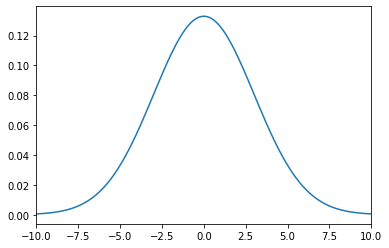

In [31]:
from scipy.stats import norm
x = np.arange(-10,10,0.01)
y = norm.pdf(x,0,3)
plt.plot(x,y)
plt.xlim(-10,10)

(-99, 99)

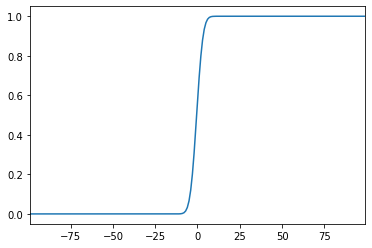

In [41]:
x = np.arange(-99,100,1)
y = norm.pdf(x , 0, 3)
plt.plot(x,np.cumsum(y))
plt.xlim(-99,99)

In [40]:
for i in np.arange(-99,100,1):
    print(i)

-99
-98
-97
-96
-95
-94
-93
-92
-91
-90
-89
-88
-87
-86
-85
-84
-83
-82
-81
-80
-79
-78
-77
-76
-75
-74
-73
-72
-71
-70
-69
-68
-67
-66
-65
-64
-63
-62
-61
-60
-59
-58
-57
-56
-55
-54
-53
-52
-51
-50
-49
-48
-47
-46
-45
-44
-43
-42
-41
-40
-39
-38
-37
-36
-35
-34
-33
-32
-31
-30
-29
-28
-27
-26
-25
-24
-23
-22
-21
-20
-19
-18
-17
-16
-15
-14
-13
-12
-11
-10
-9
-8
-7
-6
-5
-4
-3
-2
-1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [38]:
np.cumsum(y).shape

(198,)

(-10, 10)

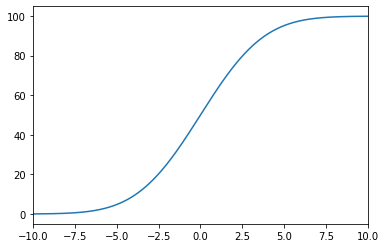

In [32]:
x = np.arange(-10,10,0.01)
y = norm.pdf(x,0,3)
plt.plot(x,np.cumsum(y))
plt.xlim(-10,10)

In [43]:
y_pred = [[0.1,0.2,0.3,0.4,0.5],[0.2,0.2,0.25,0.33,0.44],[0.11,0.12,0.3,0.4,0.5],[0.4,0.2,0.4,0.3,0.5],[0.3,0.2,0.4,0.5,0.5]]
y_pred_mean = np.mean(y_pred, axis=0)
y_pred_std = np.std(y_pred, axis=0)

print(y_pred_mean)
print(y_pred_std)

[0.222 0.184 0.33  0.386 0.488]
[0.11461239 0.032      0.06       0.06916647 0.024     ]


In [56]:
pred_df = pd.DataFrame()
a = pd.Series([1,2,3], name=0)

pred_df = pred_df.append(a)

#pred_df = pred_df.append([2,3,1])
pred_df

,0,1,2
0,1.0,2.0,3.0


In [57]:
pred_df = pd.DataFrame()
x = np.arange(-99,100,1)
for i, (mean, std) in enumerate(zip(y_pred_mean, y_pred_std)):
    tmp = pd.Series(norm.pdf(x, mean, std), name=i)
    pred_df = pred_df.append(np.cumsum(tmp))
pred_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.538809e-295,8.547009e-172,8.412610e-82,7.188737e-25,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01,5.333099e-01
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,6.625020e-297,8.247635e-07,8.247635e-07,8.247635e-07,8.247635e-07,8.247635e-07,8.247635e-07,8.247635e-07,8.247635e-07,8.247635e-07,8.247635e-07,8.247635e-07,8.247635e-07,8.247635e-07,8.247635e-07,8.247635e-07,8.247635e-07,8.247635e-07,8.247635e-07,8.247635e-07,8.247635e-07,8.247635e-07,8.247635e-07,8.247635e-07,8.247635e-07,8.247635e-07,8.247635e-07,8.247635e-07,8.247635e-07,8.247635e-07,8.247635e-07,8.247635e-07,8.247635e-07,8.247635e-07,8.247635e-07,8.247635e-07,8.247635e-07,8.247635e-07,8.247635e-07,8.247635e-07,8.247635e-07,8.247635e-07,8.247635e-07,8.247635e-07,8.247635e-07,8.247635e-07,8.247635e-07,8.247635e-07,8.247635e-07,8.247635e-07,8.247635e-07,8.247635e-07,8.247635e-07,8.247635e-07,8.247635e-07,8.247635e-07,8.247635e-07,8.247635e-07,8.247635e-07,8.247635e-07,8.247635e-07,8.247635e-07,8.247635e-07,8.247635e-07,8.247635e-07,8.247635e-07,8.247635e-07,8.247635e-07,8.247635e-07,8.247635e-07,8.247635e-07,8.247635e-07,8.247635e-07,8.247635e-07,8.247635e-07,8.247635e-07,8.247635e-07,8.247635e-07,8.247635e-07,8.247635e-07,8.247635e-07,8.247635e-07,8.247635e-07,8.247635e-07,8.247635e-07,8.247635e-07,8.247635e-07,8.247635e-07,8.247635e-0

In [47]:
[x for _ in range(len(y_pred_mean))]

[array([-99, -98, -97, -96, -95, -94, -93, -92, -91, -90, -89, -88, -87,
        -86, -85, -84, -83, -82, -81, -80, -79, -78, -77, -76, -75, -74,
        -73, -72, -71, -70, -69, -68, -67, -66, -65, -64, -63, -62, -61,
        -60, -59, -58, -57, -56, -55, -54, -53, -52, -51, -50, -49, -48,
        -47, -46, -45, -44, -43, -42, -41, -40, -39, -38, -37, -36, -35,
        -34, -33, -32, -31, -30, -29, -28, -27, -26, -25, -24, -23, -22,
        -21, -20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10,  -9,
         -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3,   4,
          5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,
         18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,
         31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,
         44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,
         57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78